In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Mounted at /content/drive
/content/drive/MyDrive/Earthquake Shelter Project


In [ ]:
import pandas as pd
import pickle
import folium
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
shelter_locations = pd.read_pickle('data/shelter/mlitt_tokyo_shelters.pkl')
shelter_locations.head()

,municality_code,name,address,type,capacity,area,earthquake,tsunami,water_damage,volcano,other,not_specified,level,notes,latitude,longitude,num,geometry
0,13101,いきいきプラザ一番町,東京都千代田区一番町12-2,指定避難所、二次避難所,-1,-1,False,False,False,False,False,True,1,None,35.686898,139.739538,1,None
1,13101,お茶の水小学校,東京都千代田区猿楽町1-1-1,指定避難所、地区救援センター,-1,-1,False,False,False,False,False,True,1,None,35.697347,139.760433,2,None
2,13101,ちよだパークサイドプラザ,東京都千代田区神田和泉町1,指定避難所、地区救援センター,-1,-1,False,False,False,False,False,True,3,None,35.699319,139.778599,3,None
3,13101,岩本町ほほえみプラザ,東京都千代田区岩本町2-15-3,指定避難所,-1,-1,False,False,False,False,False,True,3,None,35.694467,139.777894,4,None
4,13101,旧今川中学校,東京都千代田区鍛冶町2-4-2,指定避難所,-1,-1,False,False,False,False,False,True,3,None,35.691698,139.773094,5,None


In [ ]:
shelter_map = folium.Map(location=[35.6811299,139.7639996], zoom_start=12.4)
shelter_map

In [ ]:
shelter_locations_subset = shelter_locations.head(100)

In [ ]:
for _, row in shelter_locations_subset.iterrows():
  folium.Marker((row['latitude'], row['longitude'])).add_to(shelter_map)

In [ ]:
shelter_map

# Voronoi Diagram
The partitioning of a plane with n points into convex polygons such that each polygon contains exactly one generating point and every point in a given polygon is closer to its generating point than to any other. A Voronoi diagram is sometimes also known as a **Dirichlet tessellation**. The cells are called Dirichlet regions, Thiessen polytopes, or Voronoi polygons. (*Wolfram MathWorld*)

This type of diagram is created by scattering points at random on a Euclidean plane. The plane is then divided up into tessellating polygons, known as cells, one around each point, consisting of the region of the plane nearer to that point than any other. Our Voronoi pattern was in fact constructed from a set of three-dimensional points, dividing space into polyhedra. If you slice through the polyhedra you see a two-dimensional pattern of polygons, and it was this that was used to create the screen. (*University of Bristol School of Mathematics*)

All points within a **cell** (region) of the Voronoi diagram are closest to the corresponding cell shelter. In a completely ideal situation (when shelter capacity is not accounted for), all people would evacuate to that shelter.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html


In [ ]:
points = list(zip(shelter_locations_subset['latitude'], shelter_locations_subset['longitude']))

In [ ]:
shelter_voronoi = Voronoi(points)

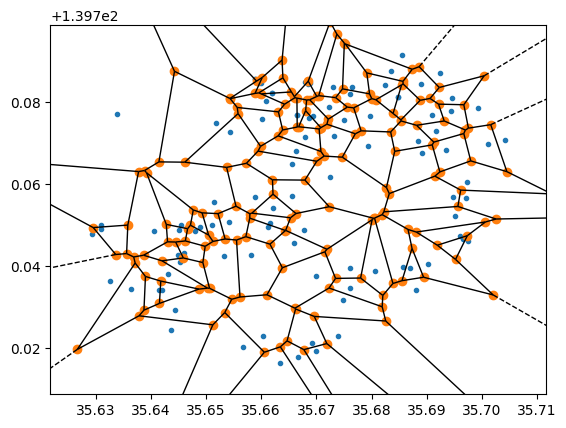

In [ ]:
fig = voronoi_plot_2d(shelter_voronoi)
plt.show()

## Dataset with only shelter capacities

2197 of 3919 entries has known shelter capacity

In [ ]:
capacity_subset = shelter_locations[shelter_locations['capacity'] != -1]
capacity_subset.head()

,municality_code,name,address,type,capacity,area,earthquake,tsunami,water_damage,volcano,other,not_specified,level,notes,latitude,longitude,num,geometry
21,13102,ほっとプラザはるみ,東京都中央区晴海5-2-3,拠点避難所,285,-1,False,False,False,False,False,True,3,None,35.651805,139.774944,22,None
22,13102,介護老人保健施設「リハポート明石」,東京都中央区明石町1-6,広域福祉避難所,145,-1,False,False,False,False,False,True,3,None,35.669421,139.776699,23,None
23,13102,久松小学校,東京都中央区久松町7-2,避難所,1560,-1,False,False,False,False,False,True,1,None,35.688958,139.784559,24,None
24,13102,京華スクエア（１、２階）,東京都中央区八丁堀3-17-9,避難所,981,-1,False,False,False,False,False,True,3,None,35.674996,139.775571,25,None
25,13102,京橋プラザ,東京都中央区銀座1-25-3,避難所,1008,-1,False,False,False,False,False,True,1,None,35.673246,139.771717,26,None


### `KMeans` Algorithm to select spread apart test data (don't know if this is the best solution because the Voronoi Diagram looks like wonky)

In [ ]:
locations = capacity_subset[['latitude', 'longitude']].copy()
num_clusters = 100

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
capacity_subset['cluster'] = kmeans.fit_predict(locations)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
repr_locations = capacity_subset.groupby('cluster').apply(lambda x: x.iloc[0])
voronoi_test_points = list(zip(repr_locations['latitude'], repr_locations['longitude']))

In [ ]:
capacity_subset_test = capacity_subset.head(100)
voronoi_test_points = list(zip(capacity_subset_test['latitude'], capacity_subset_test['longitude']))

### Unweighted Voronoi Diagram

In [ ]:
capacity_shelter_voronoi = Voronoi(voronoi_test_points)

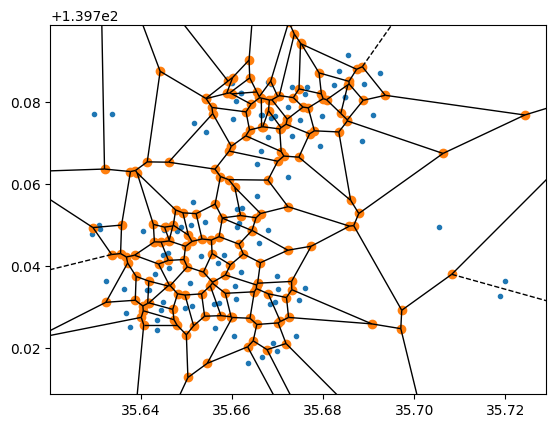

In [ ]:
voronoi_plot_2d(capacity_shelter_voronoi)
plt.show()

### Capacity-Weighted Voronoi Diagram

Normalization from 0.9 to 1.1
Normalized using a simple minmax scale, try a Gaussian Distribution centered around 1 (here, the center is prioritized)

In [ ]:
weights = list(capacity_subset_test['capacity'])
sqrt_weights = np.sqrt(weights)
normalized_weights = 0.95 + ((1.05 - 0.95) * (sqrt_weights - np.min(sqrt_weights)) / (np.max(sqrt_weights) - np.min(sqrt_weights)))

In [ ]:
adjusted_points = voronoi_test_points * normalized_weights[:, np.newaxis]

In [ ]:
voronoi_test_points[:5]

[(35.6518051004, 139.77494355),
 (35.669420992, 139.776699435),
 (35.688958, 139.784559),
 (35.6749963649, 139.775571027),
 (35.673246, 139.771717)]

In [ ]:
adjusted_points[:5]

array([[ 33.95988902, 133.14168965],
       [ 33.9350761 , 132.98037369],
       [ 34.18971356, 133.91240036],
       [ 34.10607232, 133.62848548],
       [ 34.10807793, 133.63921567]])

In [ ]:
weighted_voronoi = Voronoi(adjusted_points)
for i, region in enumerate(weighted_voronoi.regions):
  if -1 not in region and len(region) > 0:
    weighted_voronoi.regions[i] = [int(index * np.sqrt(weights)[index]) for index in region]

IndexError: index 103 is out of bounds for axis 0 with size 100

In [ ]:
len(weighted_voronoi.regions)

101

Might just be better to consult https://github.com/emunozto/weighted_voronoi/blob/master/voronoi_weighted.py

## Testing Purposes

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from math import radians, sin, cos, sqrt, atan2

In [ ]:
def haversine_distance(coords1, coords2):
    lat1, lon1 = np.radians(coords1)
    lat2, lon2 = np.radians(coords2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Radius of the Earth in kilometers
    return km

earthquake_data_raw = {
    'latitude': np.array([35.4366667, 35.2345678, 35.6789012]),
    'longitude': np.array([140.53, 140.123456, 140.789012]),
    'magnitude': np.array([5.0, 6.0, 4.5]),
    'recency': np.array([10, 15, 20])  # Example recency data in days
}
earthquake_data = pd.DataFrame(earthquake_data_raw)

def weighted_kernel_density_estimation(row):
    latitude = row['latitude']
    longitude = row['longitude']
    magnitudes = earthquake_data['magnitude'].to_numpy()
    latitudes = earthquake_data['latitude'].to_numpy()
    longitudes = earthquake_data['longitude'].to_numpy()
    recency = earthquake_data['recency'].to_numpy()

    locations = np.column_stack((latitudes, longitudes))
    distances = cdist([[latitude, longitude]], locations, haversine_distance)[0]

    recency_weights = np.exp(-recency)
    magnitude_weights = 10 ** magnitudes

    weights = recency_weights * magnitude_weights
    kde = gaussian_kde(distances, weights=weights)
    density = kde(0)

    return density[0]


# Sample DataFrame with latitude and longitude columns
data = {
    'latitude': [35.789, 35.987, 35.234],
    'longitude': [140.987, 140.567, 140.890]
}

df = pd.DataFrame(data)

# Apply the weighted_kernel_density_estimation function to create a new column
df['density'] = df.apply(weighted_kernel_density_estimation, axis=1)

print(df)

   latitude  longitude   density
0    35.789    140.987  0.001949
1    35.987    140.567  0.000321
2    35.234    140.890  0.002860


## GNN Testing Playground

In [ ]:
!pip install spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv
import networkx as nx

In [ ]:
num_nodes = 1000
num_neighbors = 10
num_features_per_node = 5

In [ ]:
G = nx.random_geometric_graph(num_nodes, radius=0.2)

In [ ]:
nodes_list = list(G.nodes)
adjacency_list = [list(G.neighbors(node)) for node in G.nodes()]
labels = np.random.randint(0, 2, size=(num_nodes,))

In [ ]:
node_inputs = Input(shape=(num_features_per_node,))
adjacency_lists_inputs = Input(shape=(None,), dtype=tf.float32)

gcnn_layer = GCNConv(64, activation='relu')([node_inputs, adjacency_lists_inputs])
gcnn_layer = Dropout(0.5)(gcnn_layer)
gcnn_layer = Dense(32, activation='relu')(gcnn_layer)

output = Dense(1, activation='sigmoid')(gcnn_layer)

In [ ]:
model = Model(inputs=[node_inputs, adjacency_lists_inputs], outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([nodes_list, adjacency_list], labels, epochs=10, batch_size=32)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {\'(<class \\\'list\\\'> containing values of types {"<class \\\'int\\\'>"})\'})', '(<class \'list\'> containing values of types {"<class \'int\'>"})'}), <class 'numpy.ndarray'>

## K Nearest Neighbor Algorithm

In [ ]:
def read_pickle(dataset_name):
  with open('data/' + dataset_name + '.pkl', 'rb') as file_:
    return pickle.load(file_)

In [ ]:
features = read_pickle('all_features')
features

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,dist_to_water,admin_code,2015,total,0-14,15-64,65+,75+,80+,shelter_count
0,53392307,35.50000,139.4625,1047954,0.00,0.00,0.05,0.00,0.739999,0.05,...,0.000000,13209,8133.3263,8428.9629,1125.1046,5516.7014,1787.1569,972.5568,536.7875,1
1,53392308,35.50000,139.4750,1047946,0.00,0.15,0.04,0.00,0.680000,0.11,...,1133.933309,13209,3263.0956,3392.0479,416.3255,2249.2543,726.4682,392.1746,239.3943,0
2,53392317,35.50833,139.4625,1047847,0.00,0.00,0.00,0.00,0.940001,0.03,...,0.000000,13209,9147.2431,9151.1161,1192.9315,6033.2625,1924.9220,1212.4851,808.1996,2
3,53392326,35.51667,139.4500,1047748,0.00,0.02,0.00,0.00,0.880001,0.01,...,0.000000,13209,8092.2569,8307.2410,1168.1542,5368.2292,1770.8576,1078.1972,652.0640,0
4,53392327,35.51667,139.4625,1047740,0.00,0.05,0.00,0.00,0.880001,0.01,...,925.174449,13209,12250.3348,12274.6534,1340.3404,7578.0816,3356.2314,2048.7194,1272.4508,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,53396107,35.83333,139.2125,1043833,0.00,0.05,0.86,0.08,0.010000,0.00,...,1459.941257,13205,21.0371,15.2681,1.4179,4.0062,9.8440,6.1216,5.1849,0
1374,53396108,35.83333,139.2250,1043824,0.00,0.03,0.91,0.04,0.020000,0.00,...,1849.483501,13205,2.0309,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
1375,53396112,35.84167,139.1500,1043773,0.00,0.00,1.00,0.00,0.000000,0.00,...,2773.751808,13308,16.9579,13.9130,0.7987,8.0011,5.1132,3.2897,2.3840,0
1376,53396201,35.83333,139.2625,1043796,0.03,0.14,0.63,0.00,0.030000,0.00,...,1459.296689,13205,194.1528,168.2823,7.3651,75.4651,85.4520,57.0754,35.6905,0


## CNN Visualization

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Resizing
from tensorflow.keras.utils import plot_model

In [3]:
RES = 32
num_channels = 26

In [6]:
model2 = Sequential([
  Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(RES, RES, num_channels)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(64, kernel_size=(3, 3), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(128, kernel_size=(3, 3), activation='relu'),
  UpSampling2D(size=(2, 2)),
  Conv2D(64, kernel_size=(3, 3), activation='relu'),
  UpSampling2D(size=(2, 2)),
  Conv2D(1, kernel_size=(3, 3), activation=None, padding='same'),
  Resizing(RES, RES)
])

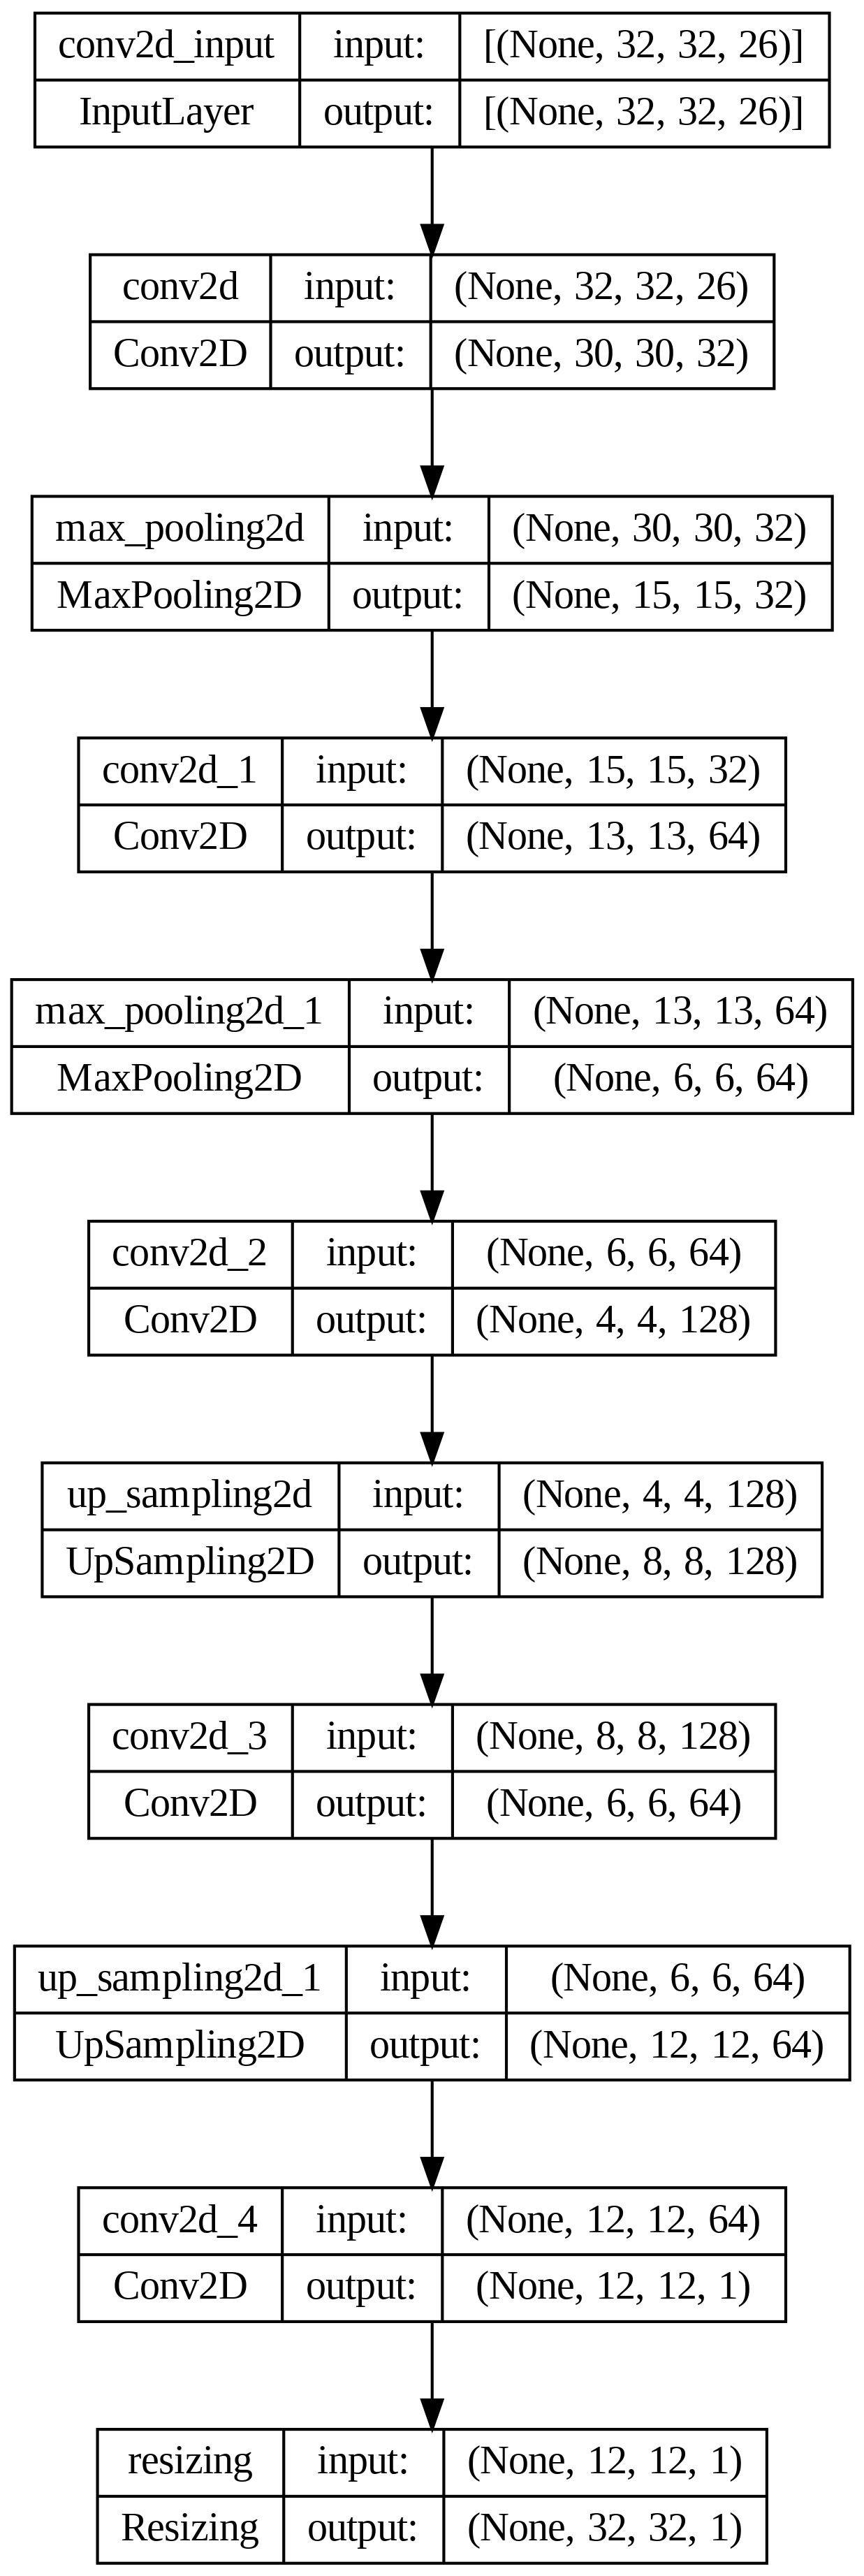

In [10]:
plot_model(model2, to_file='sequential_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=300)